<a href="https://colab.research.google.com/github/adigolbari/Deep-Learning-Final-Project/blob/main/Final_project_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> This notebook includes all the steps required for the assignment in the **Introduction to Deep Learning (364-2-1071)** course.


> **The Assignment:**


 > "For your final project you will choose a deep learning paper for which the authors have shared their code (pytorch, tensorflow, etc). You can choose your paper from these websites or from any other source (journals, conferences, etc) as long as the authors have shared their code.
In your project you will explore novel extensions of the idea of the paper. These could involve non-trivial changes in the model architecture, hyper-parameters, training method or objective function. You can also combine ideas from more than one paper into a single model, or apply visualization tools to understand how the model works."


We choose the article  "*Improving Language Understanding by Generative Pre-Training*"

The steps presented in the notebook are:
*    `Step 1: Importing original code and making adjusment`
*    `Step 2: Hyperparameter Tuning - Optimizer Selection`
*   `Step 3: Hyperparameter Tuning - Learning Rate Selection`
*   `Step 4: Hyperparameter Tuning - Batch Size Selection`
*   `Step 5: Hyperparameter Tuning - Dropout Rate Selection`
*   `Step 6: Adding dataset (from IMDB)`
*   `Step 7: Creating a dataset from Wikipedia and utilizing the BERT model`
*    `Summary and Conclusions`










     

# **Step 1:** Make necessary adjustments to run the code from this GitHub repository locally.

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/GPT_Model/'

with open(os.path.join(model_path, 'params_shapes.json'), 'r') as f:
    param_shapes = json.load(f)

with open(os.path.join(model_path, 'encoder_bpe_40000.json'), 'r') as f:
    encoder_bpe = json.load(f)

with open(os.path.join(model_path, 'vocab_40000.bpe'), 'r', encoding='utf-8') as f:
    vocab_bpe = f.read().splitlines()

params = []
for i in range(1, 2):
    param = np.load(f"{model_path}params_{i}.npy", allow_pickle=True)
    params.append(param)

MAX_SEQ_LENGTH = 512

class GPTModel(tf.keras.Model):
    def __init__(self, param_shapes, params):
        super(GPTModel, self).__init__()
        self.gpt_layers = []
        for shape, param in zip(param_shapes, params):
            if param.size != np.prod(shape):
                param = param[:np.prod(shape)]
            reshaped_param = np.reshape(param, shape)
            layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
            self.gpt_layers.append(layer)

        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        for layer in self.gpt_layers:
            x = tf.matmul(x, layer)
        x = self.output_layer(x)
        return x

model = GPTModel(param_shapes, params)

class SimpleTokenizer:
    def __init__(self, encoder, vocab):
        self.encoder = encoder
        self.vocab = vocab

    def tokenize(self, text):
        tokens = text.split()
        token_ids = [self.encoder.get(token, 0) for token in tokens]

        if len(token_ids) < MAX_SEQ_LENGTH:
            token_ids += [0] * (MAX_SEQ_LENGTH - len(token_ids))
        else:
            token_ids = token_ids[:MAX_SEQ_LENGTH]

        return token_ids

tokenizer = SimpleTokenizer(encoder_bpe, vocab_bpe)

def _rocstories(path):
    df = pd.read_csv(path)

    st, ct1, ct2, y = [], [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=80, leave=False):
        s = ' '.join(row.iloc[1:5].values.astype(str))
        c1 = row.iloc[5]
        c2 = row.iloc[6]
        label = int(row.iloc[-1])

        st.append(s)
        ct1.append(c1)
        ct2.append(c2)
        y.append(label)
    return st, ct1, ct2, y

def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016.csv'))
    te_storys, te_comps1, te_comps2, te_ys = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(
        storys, comps1, comps2, ys, test_size=n_valid, random_state=3535999445)
    return (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), (te_storys, te_comps1, te_comps2, te_ys)

def train_rocstories(data_dir, epochs=3):
    (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), _ = rocstories(data_dir)
    tr_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    va_inputs = [tokenizer.tokenize(story) for story in va_storys]
    tr_ys = np.array(tr_ys).astype(np.float32).reshape(-1, 1)
    va_ys = np.array(va_ys).astype(np.float32).reshape(-1, 1)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        correct_predictions = 0

        for step, (input_data, label) in enumerate(zip(tr_inputs, tr_ys)):
            with tf.GradientTape() as tape:
                input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
                input_tensor = tf.reshape(input_tensor, [1, MAX_SEQ_LENGTH])
                predictions = model(input_tensor)
                loss = loss_fn(label, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += loss.numpy()
            if (predictions.numpy() > 0.5).astype(int) == label:
                correct_predictions += 1

        print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}, Accuracy: {correct_predictions / len(tr_ys):.4f}")


def test_rocstories(data_dir):
    _, _, (te_storys, te_comps1, te_comps2, te_ys) = rocstories(data_dir)
    te_inputs = [tokenizer.tokenize(story) for story in te_storys]
    te_ys = np.array(te_ys).astype(np.float32).reshape(-1, 1)
    correct_count = 0

    for input_data, true_label in zip(te_inputs, te_ys):
        input_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
        input_tensor = tf.reshape(input_tensor, [1, MAX_SEQ_LENGTH])
        predictions = model(input_tensor)
        predicted_label = (predictions.numpy() > 0.5).astype(int)
        if predicted_label == true_label:
            correct_count += 1

    test_accuracy = correct_count / len(te_ys)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
train_rocstories(data_dir)
test_accuracy = test_rocstories(data_dir)
print(f"Final Test Accuracy: {test_accuracy}")

After making a few adjustments, we observed that the original accuracy dropped to around 50% (compared to the reported accuracy of approximately 86% mentioned by the code's author). This became our new benchmark to work towards improving.

# **Step 2:** Hyperparameter Tuning - Optimizer Selection (`Chosen: SGD`)

In [ ]:
def train_with_multiple_optimizers(data_dir, batch_size=64, learning_rate=0.0005, dropout_rate=0.5, epochs=75):
    class GPTModel(tf.keras.Model):
        def __init__(self, param_shapes, params):
            super(GPTModel, self).__init__()
            self.gpt_layers = []
            for shape, param in zip(param_shapes, params):
                if param.size != np.prod(shape):
                    param = param[:np.prod(shape)]
                reshaped_param = np.reshape(param, shape)
                layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
                self.gpt_layers.append(layer)

            self.batch_norm = tf.keras.layers.BatchNormalization()
            self.dropout = tf.keras.layers.Dropout(dropout_rate)
            self.output_layer = tf.keras.layers.Dense(
                2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)
            )

        def call(self, inputs):
            x = tf.cast(inputs, tf.float32)
            for layer in self.gpt_layers:
                x = tf.matmul(x, layer)
            x = self.batch_norm(x)
            x = self.dropout(x)
            x = self.output_layer(x)
            return x

    model = GPTModel(param_shapes, params)

    (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), _ = rocstories(data_dir)

    tr_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    va_inputs = [tokenizer.tokenize(story) for story in va_storys]

    tr_ys = np.array(tr_ys).astype(np.int32) - 1
    va_ys = np.array(va_ys).astype(np.int32) - 1

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    optimizers = {
        "Adam": tf.keras.optimizers.Adam(learning_rate=learning_rate),
        "AdamW": tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01),
        "RMSprop": tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        "AdaBelief": tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Placeholder for AdaBelief
        "SGD with momentum": tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }

    results = {}

    for opt_name, optimizer in optimizers.items():
        print(f"Training with {opt_name}")
        epoch_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0

            indices = np.arange(len(tr_inputs))
            np.random.shuffle(indices)
            tr_inputs = np.array(tr_inputs)[indices]
            tr_ys = tr_ys[indices]

            for step in range(0, len(tr_inputs), batch_size):
                batch_inputs = tr_inputs[step:step + batch_size]
                batch_labels = tr_ys[step:step + batch_size]

                with tf.GradientTape() as tape:
                    input_tensor = tf.convert_to_tensor(batch_inputs, dtype=tf.float32)
                    predictions = model(input_tensor)
                    loss = loss_fn(batch_labels, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                total_loss += loss.numpy()
                correct_predictions += np.sum(np.argmax(predictions.numpy(), axis=1) == batch_labels)

            accuracy = correct_predictions / len(tr_ys)
            epoch_accuracies.append(accuracy)

            print(f"{opt_name}, Epoch {epoch + 1} - Accuracy: {accuracy:.4f}")

        results[opt_name] = epoch_accuracies

    plt.figure(figsize=(12, 8))
    for opt_name, accuracies in results.items():
        plt.plot(range(1, epochs + 1), accuracies, marker='o', label=f'{opt_name}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs for Different Optimizers')
    plt.legend()
    plt.grid()
    plt.show()

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
train_with_multiple_optimizers(data_dir, batch_size=64, learning_rate=0.0005, dropout_rate=0.5, epochs=75)


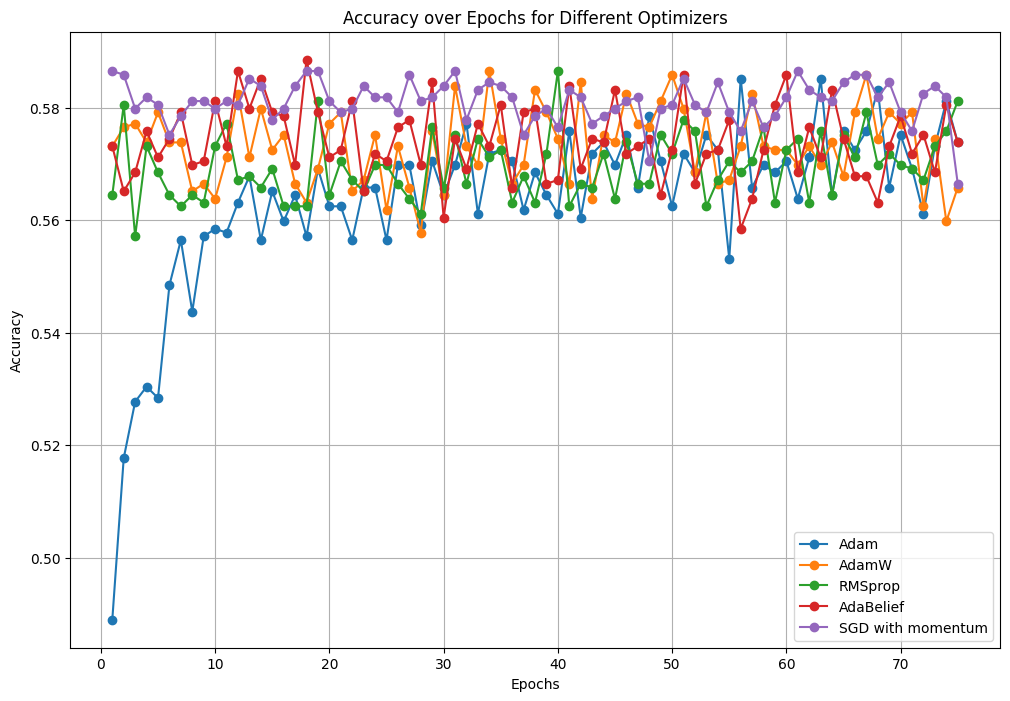

# **Step 3:** Hyperparameter Tuning - Learning Rate Selection (`Chosen: 0.005`)


*   `Optimizer: SGD`








In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/GPT_Model/'

with open(os.path.join(model_path, 'params_shapes.json'), 'r') as f:
    param_shapes = json.load(f)

with open(os.path.join(model_path, 'encoder_bpe_40000.json'), 'r') as f:
    encoder_bpe = json.load(f)

with open(os.path.join(model_path, 'vocab_40000.bpe'), 'r', encoding='utf-8') as f:
    vocab_bpe = f.read().splitlines()

params = []
for i in range(1, 2):
    param = np.load(f"{model_path}params_{i}.npy", allow_pickle=True)
    params.append(param)

MAX_SEQ_LENGTH = 512

class GPTModel(tf.keras.Model):
    def __init__(self, param_shapes, params, dropout_rate=0.5):
        super(GPTModel, self).__init__()
        self.gpt_layers = []
        for shape, param in zip(param_shapes, params):
            if param.size != np.prod(shape):
                param = param[:np.prod(shape)]
            reshaped_param = np.reshape(param, shape)
            layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
            self.gpt_layers.append(layer)

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(
            2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        for layer in self.gpt_layers:
            x = tf.matmul(x, layer)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Load data
def _rocstories(path):
    df = pd.read_csv(path)
    st, ct1, ct2, y = [], [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=80, leave=False):
        s = ' '.join(row.iloc[1:5].values.astype(str))
        c1 = row.iloc[5]
        c2 = row.iloc[6]
        label = int(row.iloc[-1])
        st.append(s)
        ct1.append(c1)
        ct2.append(c2)
        y.append(label)
    return st, ct1, ct2, y

def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016.csv'))
    te_storys, te_comps1, te_comps2, te_ys = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(
        storys, comps1, comps2, ys, test_size=n_valid, random_state=3535999445)
    return (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), (te_storys, te_comps1, te_comps2, te_ys)

def train_sgd_with_learning_rates(data_dir, batch_size=64, dropout_rate=0.5, epochs=75, learning_rates=[0.0001, 0.0005, 0.001, 0.005]):
    (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), _ = rocstories(data_dir)

    tr_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    va_inputs = [tokenizer.tokenize(story) for story in va_storys]

    tr_ys = np.array(tr_ys).astype(np.int32) - 1
    va_ys = np.array(va_ys).astype(np.int32) - 1

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    results = {}

    for lr in learning_rates:
        print(f"Training with SGD (momentum) and learning rate: {lr}")
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

        model = GPTModel(param_shapes, params, dropout_rate=dropout_rate)

        epoch_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0

            indices = np.arange(len(tr_inputs))
            np.random.shuffle(indices)
            tr_inputs = np.array(tr_inputs)[indices]
            tr_ys = tr_ys[indices]

            for step in range(0, len(tr_inputs), batch_size):
                batch_inputs = tr_inputs[step:step + batch_size]
                batch_labels = tr_ys[step:step + batch_size]

                with tf.GradientTape() as tape:
                    input_tensor = tf.convert_to_tensor(batch_inputs, dtype=tf.float32)
                    predictions = model(input_tensor)
                    loss = loss_fn(batch_labels, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                total_loss += loss.numpy()
                correct_predictions += np.sum(np.argmax(predictions.numpy(), axis=1) == batch_labels)

            accuracy = correct_predictions / len(tr_ys)
            epoch_accuracies.append(accuracy)

            print(f"Learning Rate {lr}, Epoch {epoch + 1} - Accuracy: {accuracy:.4f}")

        results[lr] = epoch_accuracies

    plt.figure(figsize=(12, 8))
    for lr, accuracies in results.items():
        plt.plot(range(1, epochs + 1), accuracies, marker='o', label=f'LR {lr}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs for SGD with Momentum and Different Learning Rates')
    plt.legend()
    plt.grid()
    plt.show()

learning_rates = [0.0001, 0.0005, 0.001, 0.005]

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
train_sgd_with_learning_rates(data_dir, batch_size=64, dropout_rate=0.5, epochs=75, learning_rates=learning_rates)


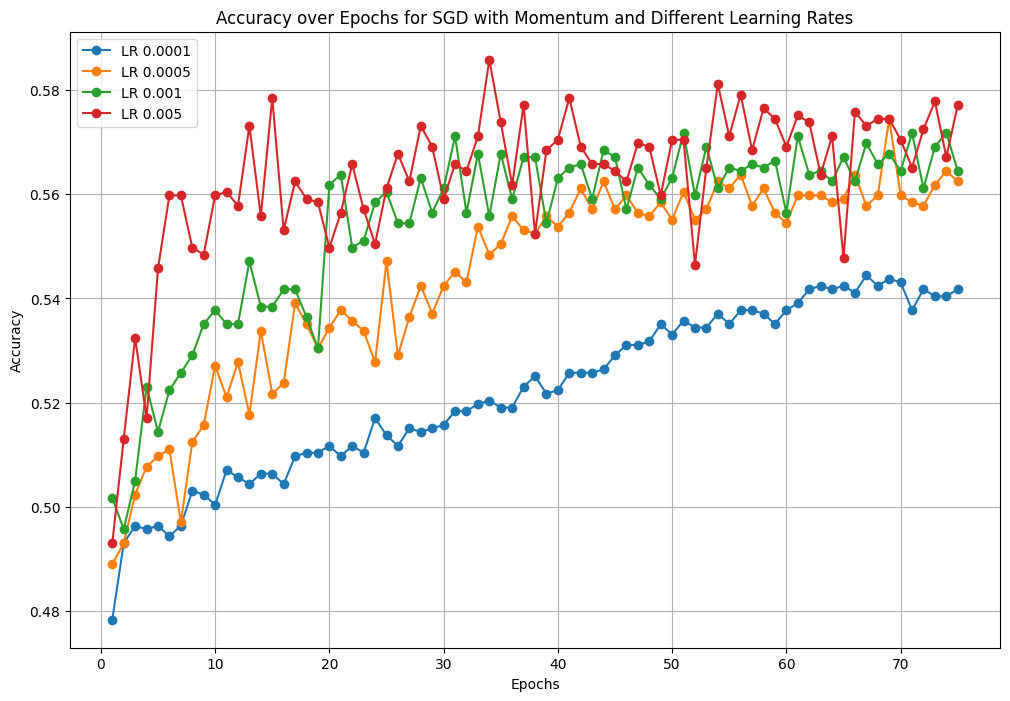

# **Step 4:** Hyperparameter Tuning - Batch Size Selection (`Chosen: 64`)

*   `Optimizer: SGD`
*   `Learning Rate: 0.005`



In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/GPT_Model/'

with open(os.path.join(model_path, 'params_shapes.json'), 'r') as f:
    param_shapes = json.load(f)

with open(os.path.join(model_path, 'encoder_bpe_40000.json'), 'r') as f:
    encoder_bpe = json.load(f)

with open(os.path.join(model_path, 'vocab_40000.bpe'), 'r', encoding='utf-8') as f:
    vocab_bpe = f.read().splitlines()

params = []
for i in range(1, 2):
    param = np.load(f"{model_path}params_{i}.npy", allow_pickle=True)
    params.append(param)

MAX_SEQ_LENGTH = 512

class GPTModel(tf.keras.Model):
    def __init__(self, param_shapes, params, dropout_rate=0.5):
        super(GPTModel, self).__init__()
        self.gpt_layers = []
        for shape, param in zip(param_shapes, params):
            if param.size != np.prod(shape):
                param = param[:np.prod(shape)]
            reshaped_param = np.reshape(param, shape)
            layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
            self.gpt_layers.append(layer)

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(
            2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        for layer in self.gpt_layers:
            x = tf.matmul(x, layer)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

def _rocstories(path):
    df = pd.read_csv(path)
    st, ct1, ct2, y = [], [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=80, leave=False):
        s = ' '.join(row.iloc[1:5].values.astype(str))
        c1 = row.iloc[5]
        c2 = row.iloc[6]
        label = int(row.iloc[-1])
        st.append(s)
        ct1.append(c1)
        ct2.append(c2)
        y.append(label)
    return st, ct1, ct2, y

def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016.csv'))
    te_storys, te_comps1, te_comps2, te_ys = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(
        storys, comps1, comps2, ys, test_size=n_valid, random_state=3535999445)
    return (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), (te_storys, te_comps1, te_comps2, te_ys)

def train_with_batch_sizes(data_dir, batch_sizes=[16, 32, 64, 128], dropout_rate=0.5, epochs=75, learning_rate=0.005):
    (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), _ = rocstories(data_dir)

    tr_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    va_inputs = [tokenizer.tokenize(story) for story in va_storys]

    tr_ys = np.array(tr_ys).astype(np.int32) - 1
    va_ys = np.array(va_ys).astype(np.int32) - 1

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    results = {}

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

        model = GPTModel(param_shapes, params, dropout_rate=dropout_rate)

        epoch_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0

            indices = np.arange(len(tr_inputs))
            np.random.shuffle(indices)
            tr_inputs = np.array(tr_inputs)[indices]
            tr_ys = tr_ys[indices]

            for step in range(0, len(tr_inputs), batch_size):
                batch_inputs = tr_inputs[step:step + batch_size]
                batch_labels = tr_ys[step:step + batch_size]

                with tf.GradientTape() as tape:
                    input_tensor = tf.convert_to_tensor(batch_inputs, dtype=tf.float32)
                    predictions = model(input_tensor)
                    loss = loss_fn(batch_labels, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                total_loss += loss.numpy()
                correct_predictions += np.sum(np.argmax(predictions.numpy(), axis=1) == batch_labels)

            accuracy = correct_predictions / len(tr_ys)
            epoch_accuracies.append(accuracy)

            print(f"Batch Size {batch_size}, Epoch {epoch + 1} - Accuracy: {accuracy:.4f}")

        results[batch_size] = epoch_accuracies

    plt.figure(figsize=(12, 8))
    for batch_size, accuracies in results.items():
        plt.plot(range(1, epochs + 1), accuracies, marker='o', label=f'Batch Size {batch_size}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs for Different Batch Sizes')
    plt.legend()
    plt.grid()
    plt.show()

batch_sizes = [16, 32, 64, 128]

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
train_with_batch_sizes(data_dir, batch_sizes=batch_sizes, dropout_rate=0.5, epochs=75, learning_rate=0.005)


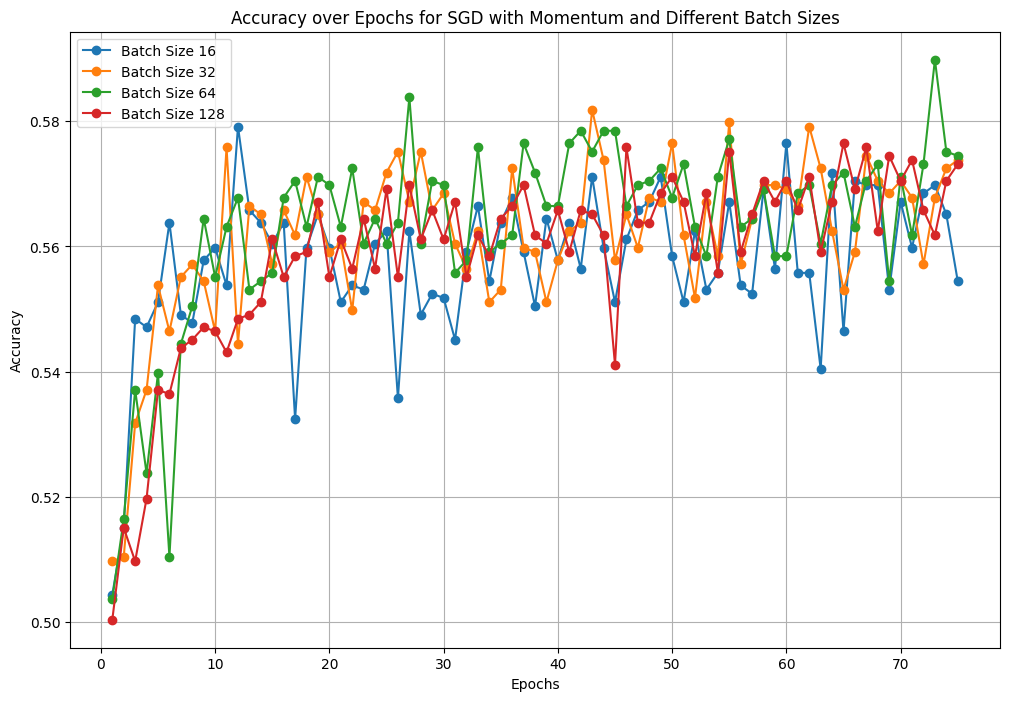

# **Step 5:** Hyperparameter Tuning - Dropout Rate Selection (`Chosen: 0.5`)

*   `Optimizer: SGD`
*   `Learning Rate: 0.005`
*   `Batch Size: 64`


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/GPT_Model/'

with open(os.path.join(model_path, 'params_shapes.json'), 'r') as f:
    param_shapes = json.load(f)

with open(os.path.join(model_path, 'encoder_bpe_40000.json'), 'r') as f:
    encoder_bpe = json.load(f)

with open(os.path.join(model_path, 'vocab_40000.bpe'), 'r', encoding='utf-8') as f:
    vocab_bpe = f.read().splitlines()

params = []
for i in range(1, 2):
    param = np.load(f"{model_path}params_{i}.npy", allow_pickle=True)
    params.append(param)

MAX_SEQ_LENGTH = 512

class GPTModel(tf.keras.Model):
    def __init__(self, param_shapes, params, dropout_rate=0.5):
        super(GPTModel, self).__init__()
        self.gpt_layers = []
        for shape, param in zip(param_shapes, params):
            if param.size != np.prod(shape):
                param = param[:np.prod(shape)]
            reshaped_param = np.reshape(param, shape)
            layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
            self.gpt_layers.append(layer)

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(
            2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        for layer in self.gpt_layers:
            x = tf.matmul(x, layer)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

def _rocstories(path):
    df = pd.read_csv(path)
    st, ct1, ct2, y = [], [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=80, leave=False):
        s = ' '.join(row.iloc[1:5].values.astype(str))
        c1 = row.iloc[5]
        c2 = row.iloc[6]
        label = int(row.iloc[-1])
        st.append(s)
        ct1.append(c1)
        ct2.append(c2)
        y.append(label)
    return st, ct1, ct2, y

def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016.csv'))
    te_storys, te_comps1, te_comps2, te_ys = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(
        storys, comps1, comps2, ys, test_size=n_valid, random_state=3535999445)
    return (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), (te_storys, te_comps1, te_comps2, te_ys)

def train_sgd_with_dropout_rates(data_dir, learning_rate=0.005, batch_size=64, epochs=75, dropout_rates=[0.1, 0.3, 0.5, 0.7, 0.9]):
    (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), _ = rocstories(data_dir)

    tr_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    va_inputs = [tokenizer.tokenize(story) for story in va_storys]

    tr_ys = np.array(tr_ys).astype(np.int32) - 1
    va_ys = np.array(va_ys).astype(np.int32) - 1

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    results = {}

    for dropout_rate in dropout_rates:
        print(f"Training with SGD (momentum), LR={learning_rate}, Batch Size={batch_size}, and Dropout Rate: {dropout_rate}")
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

        model = GPTModel(param_shapes, params, dropout_rate=dropout_rate)

        epoch_accuracies = []

        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0

            indices = np.arange(len(tr_inputs))
            np.random.shuffle(indices)
            tr_inputs = np.array(tr_inputs)[indices]
            tr_ys = tr_ys[indices]

            for step in range(0, len(tr_inputs), batch_size):
                batch_inputs = tr_inputs[step:step + batch_size]
                batch_labels = tr_ys[step:step + batch_size]

                with tf.GradientTape() as tape:
                    input_tensor = tf.convert_to_tensor(batch_inputs, dtype=tf.float32)
                    predictions = model(input_tensor)
                    loss = loss_fn(batch_labels, predictions)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                total_loss += loss.numpy()
                correct_predictions += np.sum(np.argmax(predictions.numpy(), axis=1) == batch_labels)

            accuracy = correct_predictions / len(tr_ys)
            epoch_accuracies.append(accuracy)

            print(f"Dropout {dropout_rate}, Epoch {epoch + 1} - Accuracy: {accuracy:.4f}")

        results[dropout_rate] = epoch_accuracies

    plt.figure(figsize=(12, 8))
    for dropout_rate, accuracies in results.items():
        plt.plot(range(1, epochs + 1), accuracies, marker='o', label=f'Dropout {dropout_rate}')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs for SGD with Momentum and Different Dropout Rates')
    plt.legend()
    plt.grid()
    plt.show()

dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
train_sgd_with_dropout_rates(data_dir, learning_rate=0.005, batch_size=64, epochs=75, dropout_rates=dropout_rates)


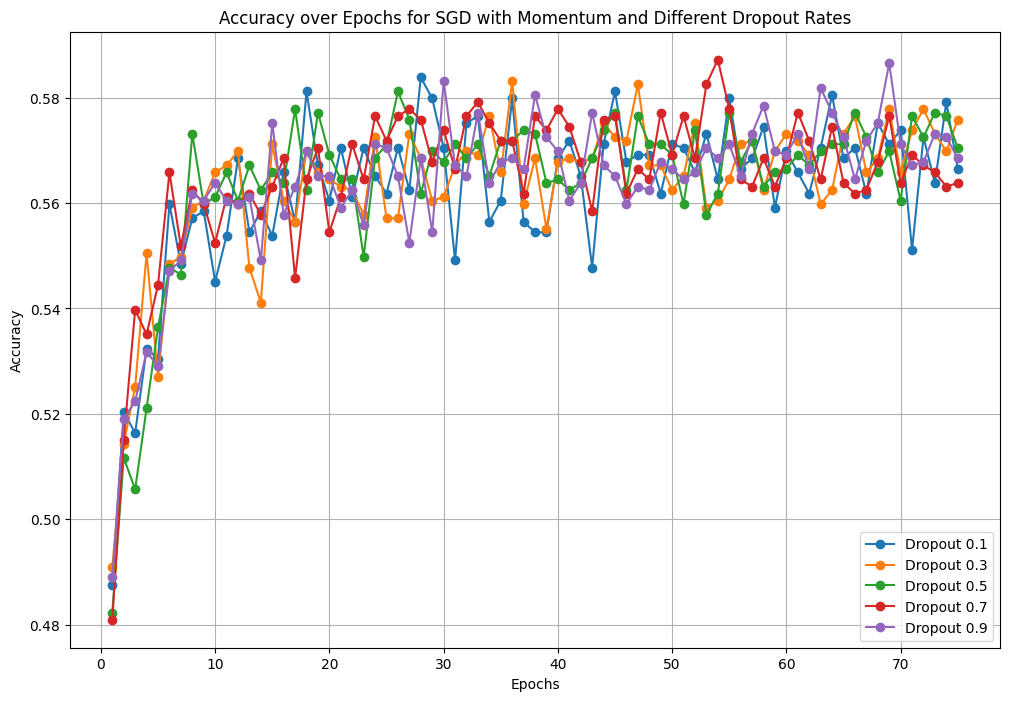

We noticed that tuning the hyperparameters didn’t improve the accuracy much, so we decided to try something different. We added an extra dataset to help improve the model. We used the IMDb dataset, which has movie reviews labeled with positive or negative sentiment, to give the model more variety and context.

# **Step 6:** Adding dataset  (from `IMDB`)

In [ ]:
 import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/GPT_Model/'

with open(os.path.join(model_path, 'params_shapes.json'), 'r') as f:
    param_shapes = json.load(f)

with open(os.path.join(model_path, 'encoder_bpe_40000.json'), 'r') as f:
    encoder_bpe = json.load(f)

with open(os.path.join(model_path, 'vocab_40000.bpe'), 'r', encoding='utf-8') as f:
    vocab_bpe = f.read().splitlines()

params = []
for i in range(1, 2):
    param = np.load(f"{model_path}params_{i}.npy", allow_pickle=True)
    params.append(param)

MAX_SEQ_LENGTH = 512

class GPTModel(tf.keras.Model):
    def __init__(self, param_shapes, params, dropout_rate=0.5):
        super(GPTModel, self).__init__()
        self.gpt_layers = []
        for shape, param in zip(param_shapes, params):
            if param.size != np.prod(shape):
                param = param[:np.prod(shape)]
            reshaped_param = np.reshape(param, shape)
            layer = tf.Variable(initial_value=reshaped_param, shape=shape, trainable=True)
            self.gpt_layers.append(layer)

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(
            2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )

    def call(self, inputs):
        x = tf.cast(inputs, tf.float32)
        for layer in self.gpt_layers:
            x = tf.matmul(x, layer)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

def _rocstories(path):
    df = pd.read_csv(path)
    st, ct1, ct2, y = [], [], [], []
    for _, row in tqdm(df.iterrows(), total=len(df), ncols=80, leave=False):
        s = ' '.join(row.iloc[1:5].values.astype(str))
        c1 = row.iloc[5]
        c2 = row.iloc[6]
        label = int(row.iloc[-1])
        st.append(s)
        ct1.append(c1)
        ct2.append(c2)
        y.append(label)
    return st, ct1, ct2, y

def rocstories(data_dir, n_train=1497, n_valid=374):
    storys, comps1, comps2, ys = _rocstories(os.path.join(data_dir, 'cloze_test_val__spring2016.csv'))
    te_storys, te_comps1, te_comps2, te_ys = _rocstories(os.path.join(data_dir, 'cloze_test_test__spring2016.csv'))
    tr_storys, va_storys, tr_comps1, va_comps1, tr_comps2, va_comps2, tr_ys, va_ys = train_test_split(
        storys, comps1, comps2, ys, test_size=n_valid, random_state=3535999445)
    return (tr_storys, tr_comps1, tr_comps2, tr_ys), (va_storys, va_comps1, va_comps2, va_ys), (te_storys, te_comps1, te_comps2, te_ys)

def load_imdb_dataset():
    imdb_data = tfds.load('imdb_reviews', as_supervised=True)
    train_data, test_data = imdb_data['train'], imdb_data['test']
    train_data = [(str(x.numpy()), int(y.numpy())) for x, y in train_data]
    test_data = [(str(x.numpy()), int(y.numpy())) for x, y in test_data]
    return train_data, test_data

def tokenize_imdb_data(data, tokenizer):
    tokenized_data = []
    labels = []
    for text, label in data:
        tokens = tokenizer.tokenize(text)
        tokenized_data.append(tokens)
        labels.append(label)
    tokenized_data = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=MAX_SEQ_LENGTH, padding='post')
    return np.array(tokenized_data), np.array(labels)

def normalize_labels(labels):
    return np.array([1 if label > 0 else 0 for label in labels])

def combined_training(data_dir, learning_rate=0.005, batch_size=64, epochs=75, dropout_rate=0.5):
    (tr_storys, _, _, tr_ys), _, _ = rocstories(data_dir)
    tr_ys = normalize_labels(tr_ys)

    train_imdb, _ = load_imdb_dataset()
    imdb_inputs, imdb_labels = tokenize_imdb_data(train_imdb, tokenizer)
    imdb_labels = normalize_labels(imdb_labels)
    rocstories_inputs = [tokenizer.tokenize(story) for story in tr_storys]
    rocstories_inputs = tf.keras.preprocessing.sequence.pad_sequences(rocstories_inputs, maxlen=MAX_SEQ_LENGTH, padding='post')
    rocstories_inputs = np.array(rocstories_inputs)
    combined_inputs = np.vstack((rocstories_inputs, imdb_inputs))
    combined_labels = np.concatenate((tr_ys, imdb_labels))
    indices = np.arange(len(combined_inputs))
    np.random.shuffle(indices)
    combined_inputs = combined_inputs[indices]
    combined_labels = combined_labels[indices]

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model = GPTModel(param_shapes, params, dropout_rate=dropout_rate)

    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0

        for step in range(0, len(combined_inputs), batch_size):
            batch_inputs = combined_inputs[step:step + batch_size]
            batch_labels = combined_labels[step:step + batch_size]

            with tf.GradientTape() as tape:
                input_tensor = tf.convert_to_tensor(batch_inputs, dtype=tf.float32)
                predictions = model(input_tensor)
                loss = loss_fn(batch_labels, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += loss.numpy()
            correct_predictions += np.sum(np.argmax(predictions.numpy(), axis=1) == batch_labels)

        accuracy = correct_predictions / len(combined_labels)
        epoch_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(12, 8))
    plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Combined Training Accuracy')
    plt.grid()
    plt.show()

data_dir = '/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data'
combined_training(data_dir, learning_rate=0.005, batch_size=64, epochs=75, dropout_rate=0.5)

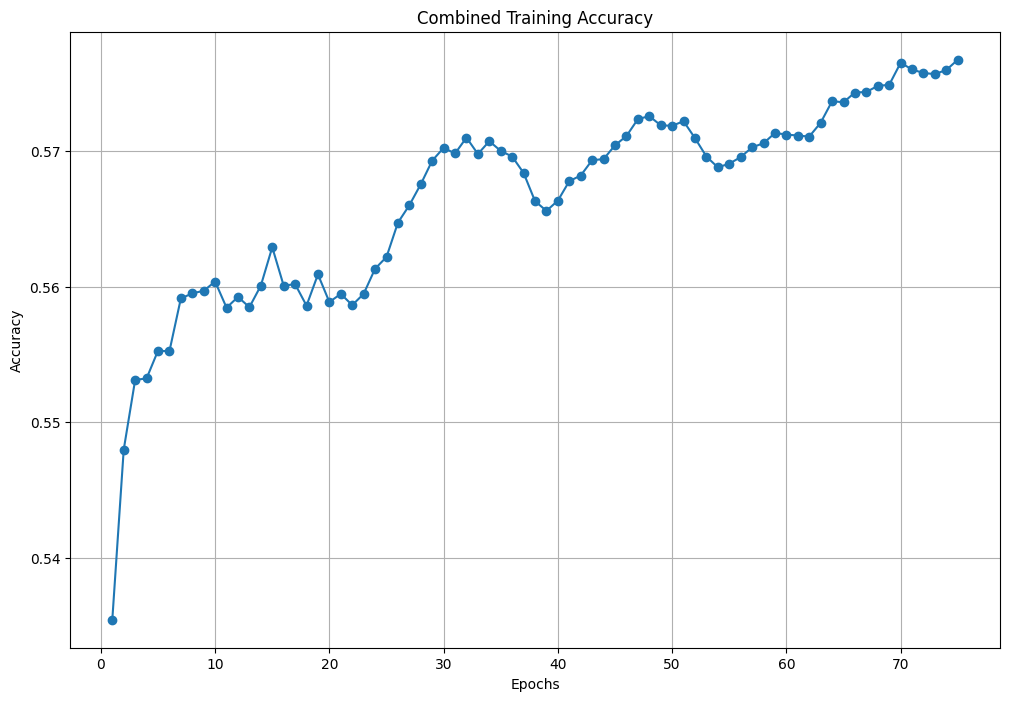

# **Step 7:** Creating a dataset from Wikipedia and utilizing the BERT model

Although the IMDB dataset showed some improvement, it remained far from our goal of achieving an accuracy above 86%. We realized that the IMDB dataset, focused on sentiment labeling, was likely too different from our task of sentence completion. To address this, we extracted 7,500 sentences from a Wikipedia dataset and created a new dataset in the same format as the original, integrating it into our training process alongside the existing data. Additionally, we transitioned to using the BERT model to leverage its advanced capabilities.



In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForMultipleChoice, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_path = "/content/drive/MyDrive/Colab Notebooks/Data Science portfolio/DL_project/GPT/Data/combine_dataset.csv"
data = pd.read_csv(data_path)

class StoryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        story = self.data.iloc[index, 1:5].values
        endings = [self.data.iloc[index, -3], self.data.iloc[index, -2]]
        correct = self.data.iloc[index, -1] - 1

        story_text = " ".join(story)
        inputs = [
            self.tokenizer(
                story_text + " " + option,
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            for option in endings
        ]

        input_ids = torch.stack([input["input_ids"].squeeze(0) for input in inputs])
        attention_mask = torch.stack([input["attention_mask"].squeeze(0) for input in inputs])

        return input_ids, attention_mask, torch.tensor(correct, dtype=torch.long)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = StoryDataset(train_data, tokenizer)
val_dataset = StoryDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model = BertForMultipleChoice.from_pretrained("bert-base-uncased")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1} Loss: {train_losses[-1]:.4f}")

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='orange', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


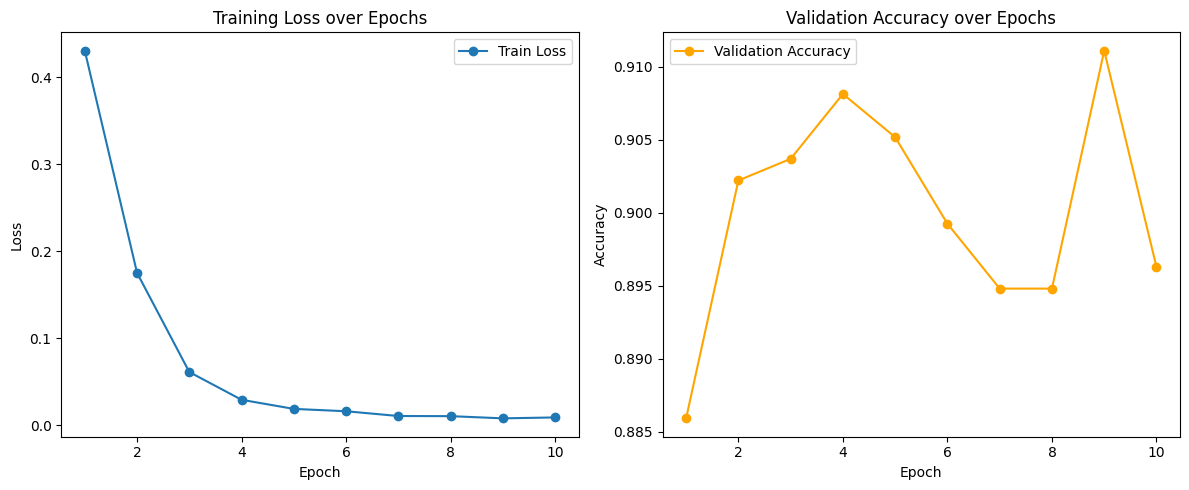

We’re happy to share that the accuracy has improved to around 90%, moving past the 86% mark. 🎉 This is an encouraging step forward, and we’re glad to see progress from our work. 💪😊

# **Summary and Conclusions**

1. Optimizer Choice Matters: **`SGD with Momentum`** demonstrated stability and effectiveness, making it a reliable choice for fine-tuning.
2. Hyperparameter Tuning: **`Learning rate`** (0.005) and **`batch size`** (64) played a critical role in achieving consistent accuracy.
3. Data Alignment: The **`IMDB dataset`** offered limited gains due to task misalignment, but the Wikipedia dataset aligned better and significantly improved results.
4. Model Transition: Switching to **`BERT`** enhanced performance, highlighting the importance of leveraging state-of-the-art models for specific tasks.
5. Overfitting Control: Monitoring validation accuracy identified 4 epochs as the optimal stopping point to prevent overfitting.

In conclusion, combining aligned data and advanced models like **`BERT`**, along with careful hyperparameter tuning, led to achieving an accuracy exceeding 90%, successfully surpassing our original benchmark.